# Tarea Integradora 02: Detección de Fraude con Tarjetas de Crédito

**Dataset:** *Credit Card Fraud Detection* (Kaggle)

Este dataset contiene 284.807 transacciones realizadas con tarjeta de crédito en septiembre de 2013 por titulares europeos. De estas, 492 son fraudes (≈0.17%). El objetivo de esta tarea es aplicar técnicas de aprendizaje automático en un contexto realista y altamente desbalanceado.

## Objetivos de Aprendizaje

1. Comprender el impacto del desbalance de clases en problemas reales.
2. Explorar y analizar un dataset financiero con fuerte desbalance.
3. Aplicar técnicas de preprocesamiento y re-muestreo (undersampling, oversampling, SMOTE).
4. Entrenar y comparar modelos de clasificación (Regresión Logística, Árboles de Decisión, Random Forest, Gradient Boosting).
5. Evaluar modelos con métricas adecuadas para datasets desbalanceados (Precision, Recall, F1, AUC-ROC, AUC-PR).
6. Reflexionar sobre los trade-offs entre precisión y recall en un problema crítico como el fraude.

# 0. Setup Básico

- Descargar el dataset desde Kaggle.
- Reportar el número de transacciones normales y fraudulentas.
- Calcular y graficar la proporción de fraude.

In [ ]:
# ----- 0. Importar librerías -----

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix, average_precision_score,
    roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler


In [209]:
# ----- 1. Cargar y explorar el dataset -----
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Características del dataset

Solo contiene variables numericas que son el resultado de una trasformación de PCA.
Desafortunadamente, por problemas confidenciales, no se puede proveer de las columnas originales ni más información adicional sobre los datos.

Las columnas `V1`, `V2`, `V28` son los componentes principales obtenidos con PCA, las únicas columnas que no fueron transformadas con PCA son `Time` y `Amount`.

La columna `Time` contiene el tiempo transcurrido entre la primer transacción del dataset y la seleccionada.

La columna `Amount` es la cantidad de dinero transaccionado.

La columna `Class` es la variable de respuesta y toma los valores (1 = en caso de fraude, y 0 = en caso contrario).

Dado el coeficiente de desequilibrio de clases, recomendamos medir la precisión utilizando el Área Bajo la Curva de Precisión-Recall (AUPRC). La precisión de la matriz de confusión no es significativa para la clasificación desequilibrada.

Total de casos (1 = Fraude, 0 = No Fraude)
Class
0    284315
1       492
Name: count, dtype: int64
Proporción de fraude: 0.0017


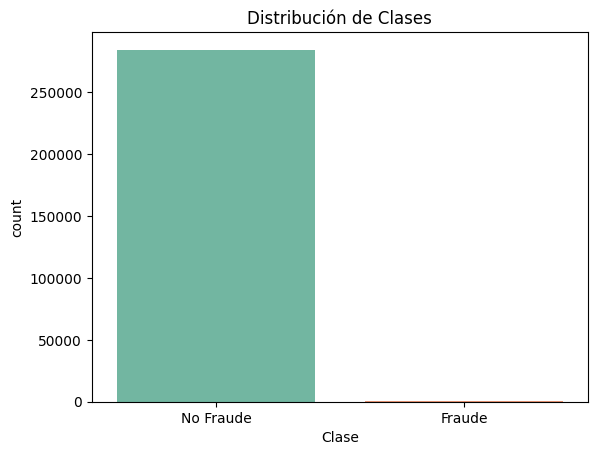

In [210]:
# ----- 2. Reporte básico del dataset -----

print(f"Total de casos (1 = Fraude, 0 = No Fraude)\n{df['Class'].value_counts()}")

fraud_ratio = df['Class'].mean()
print(f'Proporción de fraude: {fraud_ratio:.4f}')

x = df['Class'].map({0: 'No Fraude', 1: 'Fraude'})
sns.countplot(
    x= x,
    palette='Set2',
    hue=x
)
plt.xlabel('Clase')
plt.title('Distribución de Clases') 
plt.show()

# 1. Análisis exploratorio

- Verificar si las variables requieren normalización o escalado.
- Analizar la distribución de la variable Amount y el comportamiento de la variable Time.

In [211]:
# Las columnas V1 a V28 son el resultado de una transformación PCA. Por lo tanto, ya están normalizadas.
# Sin embargo para las columnas 'Time' y 'Amount' serán analizadas para saber si necesitan escalado.
# ----- 3. Análisis de las columnas Time y Amount -----

min_time = df['Time'].min()
max_time = df['Time'].max()
print(f'Rango de la columna Time: {min_time} a {max_time}')

min_amount = df['Amount'].min()
max_amount = df['Amount'].max()
print(f'Rango de la columna Amount: {min_amount} a {max_amount}')

# --- Estadísticas descriptivas ---
descriptive = df[['Time', 'Amount']].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T # Paso las columnas ('Time' y 'Amount') como filas para luego añadir las columnas 'skew' y 'kurtosis'
descriptive['skew'] = df[['Time', 'Amount']].skew()
descriptive['kurtosis'] = df[['Time', 'Amount']].kurtosis()

display(descriptive)

Rango de la columna Time: 0.0 a 172792.0
Rango de la columna Amount: 0.0 a 25691.16


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,kurtosis
Time,284807.0,94813.859575,47488.145955,0.0,2422.00,25297.60,54201.5,84692.0,139320.500,164143.4,170560.94,172792.00,-0.035568,-1.293530
Amount,284807.0,88.349619,250.120109,0.0,0.12,0.92,5.6,22.0,77.165,365.0,1017.97,25691.16,16.977724,845.092646


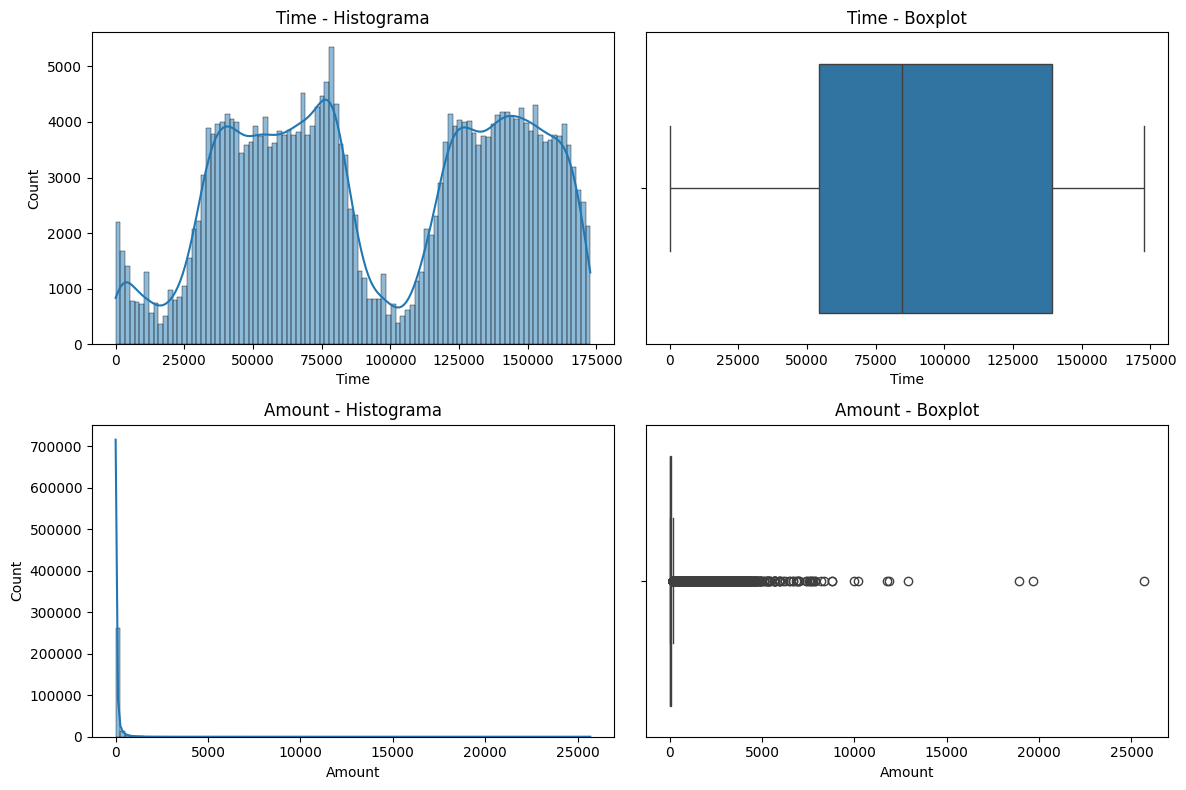

In [212]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df['Time'], bins=100, kde=True, ax=axes[0,0])
axes[0,0].set_title('Time - Histograma')

sns.boxplot(x=df['Time'], ax=axes[0,1])
axes[0,1].set_title('Time - Boxplot')

sns.histplot(df['Amount'], bins=100, kde=True, ax=axes[1,0])
axes[1,0].set_title('Amount - Histograma')

sns.boxplot(x=df['Amount'], ax=axes[1,1])
axes[1,1].set_title('Amount - Boxplot')
plt.tight_layout()
plt.show()


**Columna `Time`**

- Media ≈ 94,813
- Rango: 0 – 172,792 (≈ 2 días)
- Skewness ≈ -0.035 (muy cerca de 0 → simétrica).
- Kurtosis ≈ -1.29 (distribución más plana que la normal → no heavy-tailed).

`Time` esta bastante balanceado y no muestro un sesgo fuerte.

Al usar modelos sensibles a magnitudes (LogisticRegression, SVM, NN) es necesario escalar.

**Columna `Amount`**

- Media ≈ 88, pero std ≈ 250 (muy disperso).
- Percentiles:
  - 50% de los valores ≤ 22.0
  - 75% ≤ 77.1
  - 95% ≤ 365
  - 99% ≤ 1017.9
- Máximo = 25,691 (demasiados outliers fuertes).
- Skewness = 16.98 (altamente sesgada a la derecha).
- Kurtosis = 845 (cola muy pesada: outliers extremos).

Amount es la típica variable monetaria con muchos valores pequeños y pocas transacciones muy grandes.

Necesita transformación logarítmica (np.log1p) para corregir la asimetría.

Conviene luego aplicar RobustScaler (mejor que StandardScaler) porque no se deja influenciar tanto por los outliers.

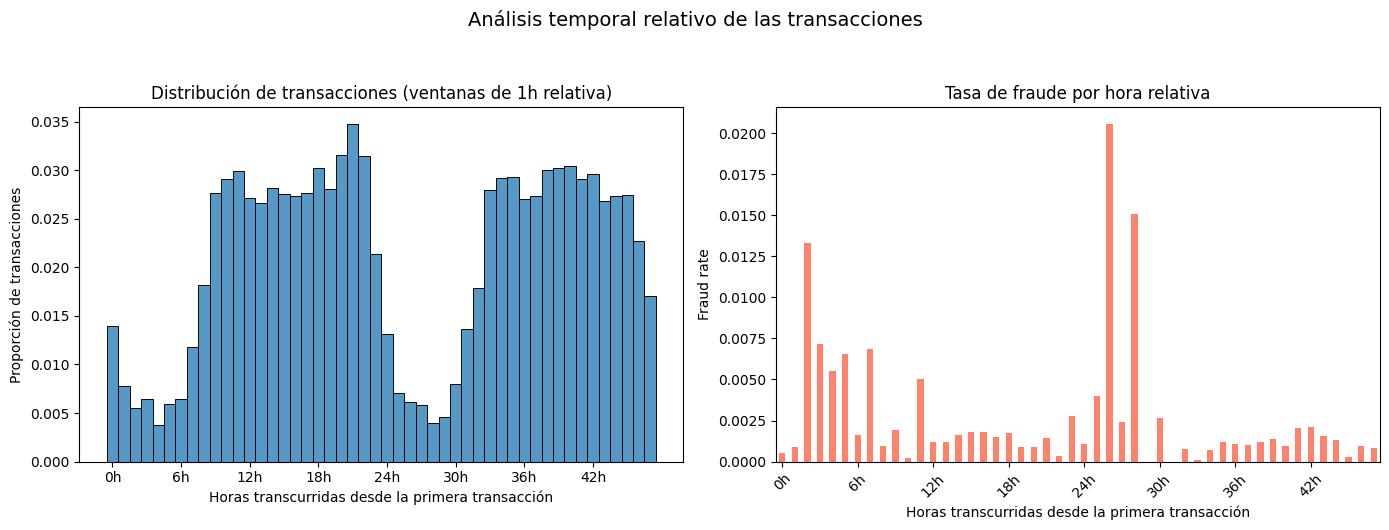

In [213]:
# --- Análisis temporal relativo en ventanas de 1 hora ---
SECONDS_PER_HOUR = 3600

# Crear columna con el índice de hora relativa desde la primera transacción
df['RelativeHour'] = (df['Time'] // SECONDS_PER_HOUR).astype(int)

fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Distribución de transacciones por hora relativa
sns.histplot(
    data=df,
    x="RelativeHour",
    bins=df['RelativeHour'].nunique(),  # un bin por hora
    discrete=True,
    stat="density",
    ax=ax[0]
)
ax[0].set_title("Distribución de transacciones (ventanas de 1h relativa)", fontsize=12)
ax[0].set_xlabel("Horas transcurridas desde la primera transacción")
ax[0].set_ylabel("Proporción de transacciones")
ax[0].set_xticks(range(0, df['RelativeHour'].max()+1, 6))
ax[0].set_xticklabels([f"{h}h" for h in range(0, df['RelativeHour'].max()+1, 6)])

# Tasa de fraude por hora relativa
fraud_rate_by_hour = df.groupby('RelativeHour')['Class'].mean()
fraud_rate_by_hour.plot(kind='bar', color="tomato", alpha=0.8, ax=ax[1])
ax[1].set_title("Tasa de fraude por hora relativa", fontsize=12)
ax[1].set_xlabel("Horas transcurridas desde la primera transacción")
ax[1].set_ylabel("Fraud rate")
ax[1].set_xticks(range(0, df['RelativeHour'].max()+1, 6))
ax[1].set_xticklabels([f"{h}h" for h in range(0, df['RelativeHour'].max()+1, 6)], rotation=45)

plt.suptitle("Análisis temporal relativo de las transacciones", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


A través del análisis del tiempo, se puede notar que cuando hay menos transacciones es cuando hay más fraudes. Lo que me lleva a pensar que: en la madrugada hay menos transacciones por lo tanto, en la madrugada se da la mayor cantidad de fraudes. Pero solo es suposición. 

Skew Amount: 16.978
Skew log1p(Amount): 0.163


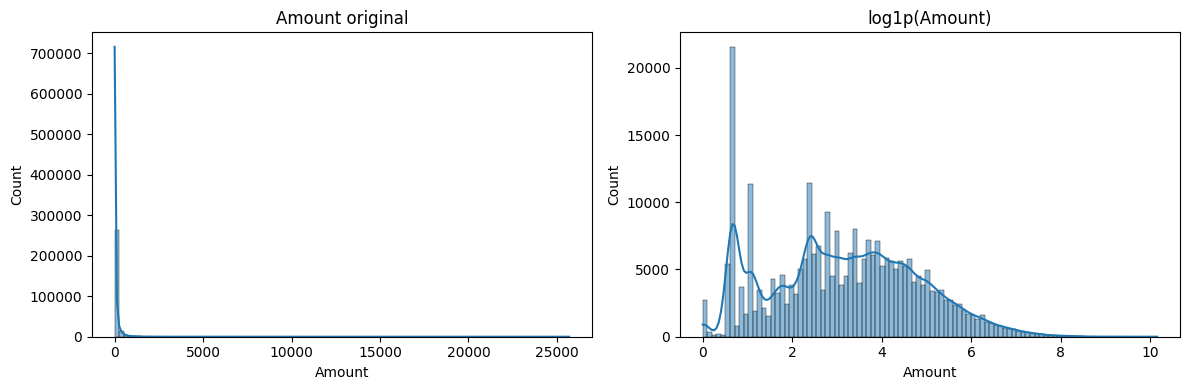

In [214]:
# --- Justificación de transformación de la variable Amount ---

amount_skew = df['Amount'].skew()
amount_log_skew = np.log1p(df['Amount']).skew()

print(f"Skew Amount: {amount_skew:.3f}")
print(f"Skew log1p(Amount): {amount_log_skew:.3f}")

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Amount'], bins=100, kde=True, ax=ax[0])
ax[0].set_title('Amount original')

sns.histplot(np.log1p(df['Amount']), bins=100, kde=True, ax=ax[1])
ax[1].set_title('log1p(Amount)')
plt.tight_layout()
plt.show()


**¿Para qué se usa en este problema?**

`Amount` suele estar muy sesgado a la derecha y con outliers. `log1p`:
- Comprime grandes valores (reduce la cola).
- Reduce la asimetría (skew) → modelos lineales como la Regresión Logística suelen comportarse mejor.
- Después de log1p, es común aplicar un escalado robusto (RobustScaler) para atenuar aún más outliers.

# 2. Modelo base

- Separar train/test usando `stratify=y`.
- Entrenar un modelo de Regresión Logística sin re-balanceo.
- Reportar métricas: `Accuracy, Balanced Accuracy, Precision, Recall, F1, AUC-ROC, AUC-PR`.

In [215]:
# ----- 4. Separación de Train/Test 80/20 -----
X = df.drop(columns='Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [216]:
# ----- 5. Preprocesamiento de las columnas -----

pca_cols = [c for c in df.columns if c.startswith('V')]
time_col = ['Time']
amount_col = ['Amount']

# Aplica log(1 + x) 
log1p = FunctionTransformer(lambda x: np.log1p(np.clip(x, a_min=0, a_max=None))) # np.clip() asegura que no hayan negativos, reemplaza valores <0 por 0. 

pre = ColumnTransformer([
    ('time_std', StandardScaler(), time_col),
    ('amount_log_robust', Pipeline([('log1p', log1p), ('robust', RobustScaler())]), amount_col),
    ('pca_passthrough', 'passthrough', pca_cols)
])

In [ ]:
# ----- 6. Regresión Logística sin re-balanceo -----

log_reg = LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)

clf = Pipeline([
    ('pre', pre), 
    ('model', log_reg)
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba),
    "PR-AUC": average_precision_score(y_test, y_proba)
}

# --- Mostrar como tabla ordenada ---
results = pd.DataFrame(metrics, index=["Logistic Regression (sin rebalanceo)"]).T
display(results.style.format("{:.4f}"))

,Logistic Regression (sin rebalanceo)
Accuracy,0.9992
Balanced Accuracy,0.8213
Precision,0.8289
Recall,0.6429
F1,0.7241
ROC-AUC,0.9571
PR-AUC,0.7390


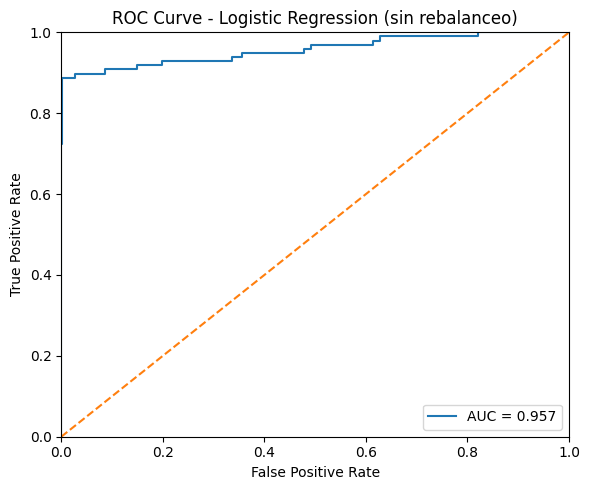

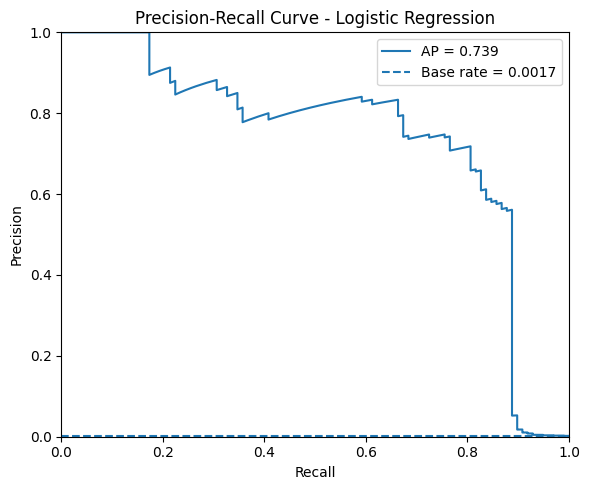

In [218]:
# --- Curvas ROC y PR ---
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (sin rebalanceo)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR - Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
baseline = (y_test.sum() / len(y_test))  # línea base PR = prevalencia de la clase positiva

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Base rate = {baseline:.4f}")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

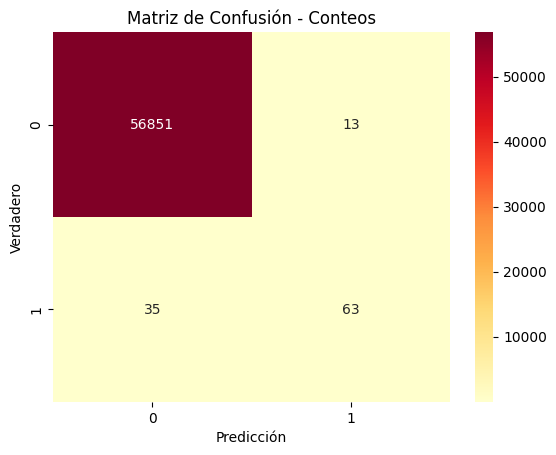

In [219]:
# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)  # [[TN, FP],[FN, TP]]

# Conteos absolutos
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Matriz de Confusión - Conteos")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

# 3. Tratamiento del desbalance

- Aplicar al menos dos técnicas distintas:
    - Uso de `class_weight='balanced'` en modelos.
  - Re-muestreo con `SMOTE` (o variantes).
  - Undersampling de la clase mayoritaria.
- Comparar los resultados de las métricas.

In [220]:
# ----- 7. Regresión Logística con re-balanceo (class_weight='balanced') -----

log_reg_balanced = LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1, class_weight='balanced')
clf_balanced = Pipeline([
    ('pre', pre),
    ('model', log_reg_balanced)
])

clf_balanced.fit(X_train, y_train)

y_pred_balanced = clf_balanced.predict(X_test)
y_proba_balanced = clf_balanced.predict_proba(X_test)[:,1]

metrics_balanced = {
    "Accuracy": accuracy_score(y_test, y_pred_balanced),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_balanced),
    "Precision": precision_score(y_test, y_pred_balanced),
    "Recall": recall_score(y_test, y_pred_balanced),
    "F1": f1_score(y_test, y_pred_balanced),
    "ROC-AUC": roc_auc_score(y_test, y_proba_balanced),
    "PR-AUC": average_precision_score(y_test, y_proba_balanced)
}

# --- Mostrar como tabla ordenada ---
results_balanced = pd.DataFrame(metrics_balanced, index=["Logistic Regression (balanceadas)"]).T
display(results_balanced.style.format("{:.4f}"))


,Logistic Regression (balanceadas)
Accuracy,0.9753
Balanced Accuracy,0.9469
Precision,0.0604
Recall,0.9184
F1,0.1133
ROC-AUC,0.9712
PR-AUC,0.7114


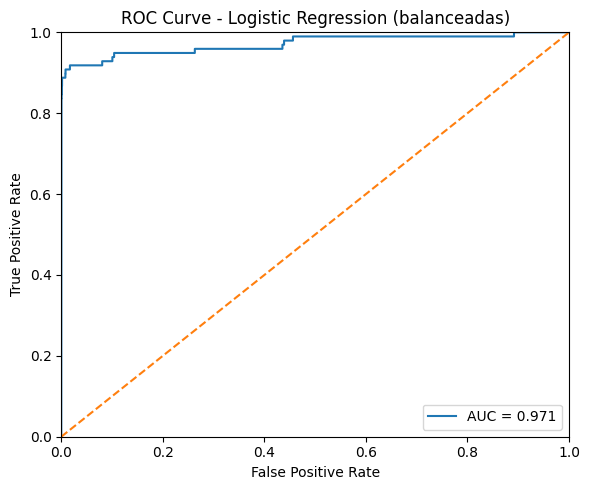

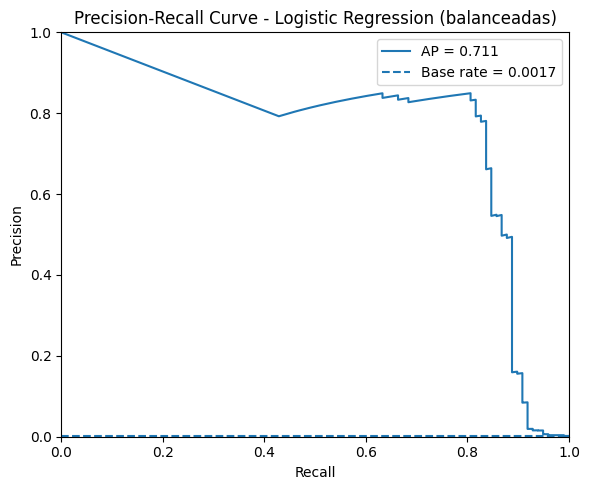

In [221]:
# --- Curvas ROC y PR ---
# ROC
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_proba_balanced)
roc_auc_balanced = roc_auc_score(y_test, y_proba_balanced)

plt.figure(figsize=(6,5))
plt.plot(fpr_balanced, tpr_balanced, label=f"AUC = {roc_auc_balanced:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (balanceadas)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR - Precision-Recall Curve
prec_balanced, rec_balanced, _ = precision_recall_curve(y_test, y_proba_balanced)
ap_balanced = average_precision_score(y_test, y_proba_balanced)
baseline_balanced = (y_test.sum() / len(y_test))  # línea base PR = prevalencia de la clase positiva

plt.figure(figsize=(6,5))
plt.plot(rec_balanced, prec_balanced, label=f"AP = {ap_balanced:.3f}")
plt.hlines(baseline_balanced, 0, 1, linestyles="--", label=f"Base rate = {baseline_balanced:.4f}")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression (balanceadas)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

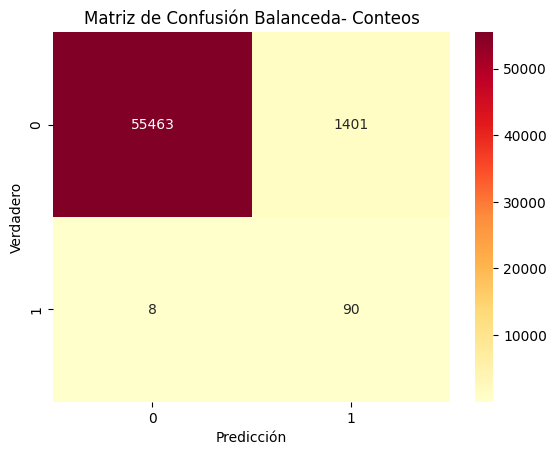

In [222]:
# --- Matriz de confusión ---
cm_balanced = confusion_matrix(y_test, y_pred_balanced)  # [[TN, FP],[FN, TP]]

# Conteos absolutos
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Matriz de Confusión Balanceda- Conteos")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [223]:
# ----- 8. Regresión Logística con SMOTE -----

smote = SMOTE(random_state=42)

clf_smote = ImbPipeline([
    ("pre", pre),
    ("smote", smote),
    ("model", log_reg)
])

clf_smote.fit(X_train, y_train)

y_pred_smote = clf_smote.predict(X_test)
y_proba_smote = clf_smote.predict_proba(X_test)[:,1]

metrics_smote = {
    "Accuracy": accuracy_score(y_test, y_pred_smote),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_smote),
    "Precision": precision_score(y_test, y_pred_smote),
    "Recall": recall_score(y_test, y_pred_smote),
    "F1": f1_score(y_test, y_pred_smote),
    "ROC-AUC": roc_auc_score(y_test, y_proba_smote),
    "PR-AUC": average_precision_score(y_test, y_proba_smote)
}

# --- Mostrar como tabla ordenada ---
results_smote = pd.DataFrame(metrics_smote, index=["Logistic Regression (SMOTE)"]).T
display(results_smote.style.format("{:.4f}"))


,Logistic Regression (SMOTE)
Accuracy,0.9741
Balanced Accuracy,0.9463
Precision,0.0579
Recall,0.9184
F1,0.1089
ROC-AUC,0.9693
PR-AUC,0.7220


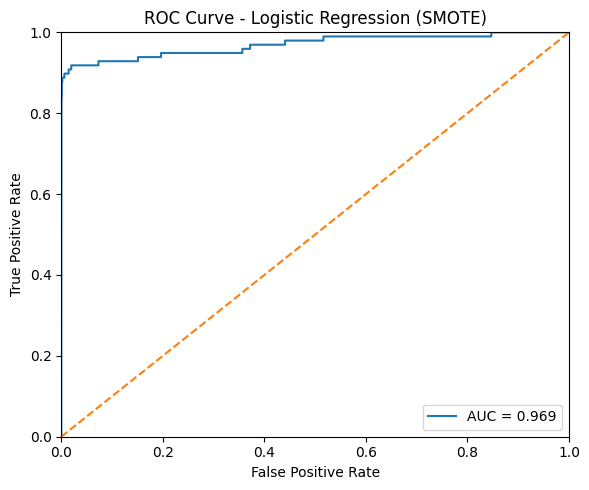

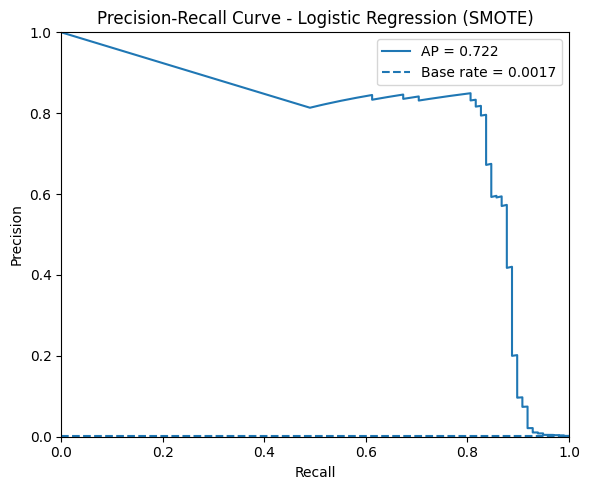

In [224]:
# --- Curvas ROC y PR ---
# ROC
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)

plt.figure(figsize=(6,5))
plt.plot(fpr_smote, tpr_smote, label=f"AUC = {roc_auc_smote:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (SMOTE)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR - Precision-Recall Curve
prec_smote, rec_smote, _ = precision_recall_curve(y_test, y_proba_smote)
ap_smote = average_precision_score(y_test, y_proba_smote)
baseline_smote = (y_test.sum() / len(y_test))  # línea base PR = prevalencia de la clase positiva

plt.figure(figsize=(6,5))
plt.plot(rec_smote, prec_smote, label=f"AP = {ap_smote:.3f}")
plt.hlines(baseline_smote, 0, 1, linestyles="--", label=f"Base rate = {baseline_smote:.4f}")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression (SMOTE)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

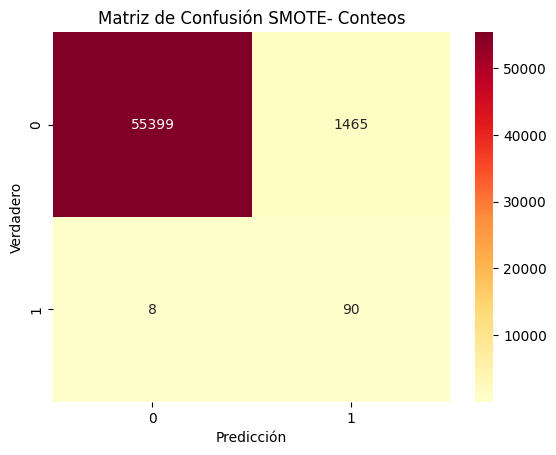

In [225]:
# --- Matriz de confusión ---
cm_smote = confusion_matrix(y_test, y_pred_smote)  # [[TN, FP],[FN, TP]]

# Conteos absolutos
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Matriz de Confusión SMOTE- Conteos")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [226]:
# ----- 9. Regresión Logística con Undersampling -----
under = RandomUnderSampler(random_state=42)

clf_under = ImbPipeline([
    ("pre", pre),
    ("under", under),
    ("model", log_reg)
])

clf_under.fit(X_train, y_train)

y_pred_under = clf_under.predict(X_test)
y_proba_under = clf_under.predict_proba(X_test)[:,1]

metrics_under = {
    "Accuracy": accuracy_score(y_test, y_pred_under),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_under),
    "Precision": precision_score(y_test, y_pred_under),
    "Recall": recall_score(y_test, y_pred_under),
    "F1": f1_score(y_test, y_pred_under),
    "ROC-AUC": roc_auc_score(y_test, y_proba_under),
    "PR-AUC": average_precision_score(y_test, y_proba_under)
}

# --- Mostrar como tabla ordenada ---
results_under = pd.DataFrame(metrics_under, index=["Logistic Regression (Undersampling)"]).T
display(results_under.style.format("{:.4f}"))

,Logistic Regression (Undersampling)
Accuracy,0.9587
Balanced Accuracy,0.9386
Precision,0.0370
Recall,0.9184
F1,0.0711
ROC-AUC,0.9764
PR-AUC,0.6244


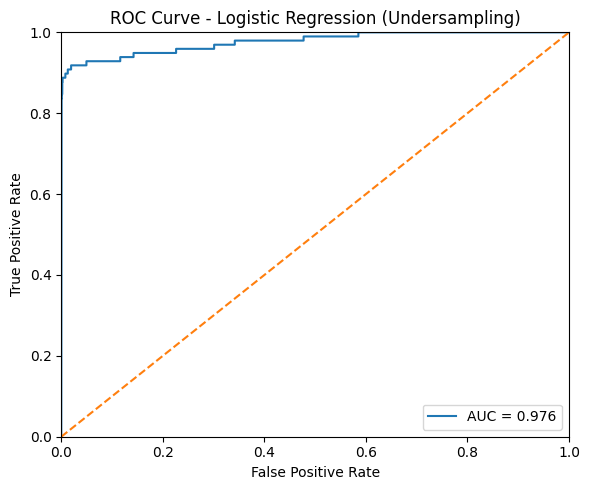

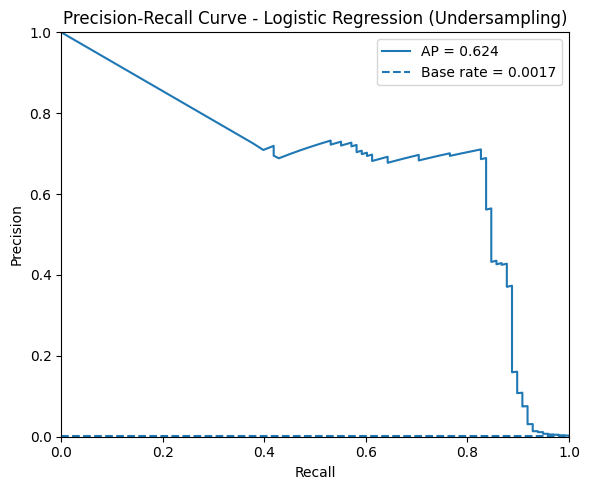

In [227]:
# --- Curvas ROC y PR ---
# ROC
fpr_under, tpr_under, _ = roc_curve(y_test, y_proba_under)
roc_auc_under = roc_auc_score(y_test, y_proba_under)

plt.figure(figsize=(6,5))
plt.plot(fpr_under, tpr_under, label=f"AUC = {roc_auc_under:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Undersampling)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR - Precision-Recall Curve
prec_under, rec_under, _ = precision_recall_curve(y_test, y_proba_under)
ap_under = average_precision_score(y_test, y_proba_under)
baseline_under = (y_test.sum() / len(y_test))  # línea base PR = prevalencia de la clase positiva

plt.figure(figsize=(6,5))
plt.plot(rec_under, prec_under, label=f"AP = {ap_under:.3f}")
plt.hlines(baseline_under, 0, 1, linestyles="--", label=f"Base rate = {baseline_under:.4f}")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression (Undersampling)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

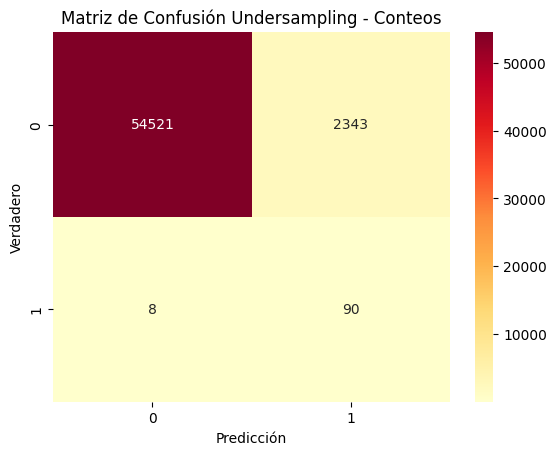

In [228]:
# --- Matriz de confusión ---
cm_under = confusion_matrix(y_test, y_pred_under)  # [[TN, FP],[FN, TP]]

# Conteos absolutos
sns.heatmap(cm_under, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Matriz de Confusión Undersampling - Conteos")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [229]:
# ----- 10. Comparación de resultados -----
df_all = pd.concat(
    {
        "Baseline": results,
        "Balanced": results_balanced,
        "SMOTE": results_smote,
        "Undersampling": results_under
    },
    axis=1
)

display(df_all)


,Baseline,Balanced,SMOTE,Undersampling
,Logistic Regression (sin rebalanceo),Logistic Regression (balanceadas),Logistic Regression (SMOTE),Logistic Regression (Undersampling)
Accuracy,0.999157,0.975264,0.974141,0.958727
Balanced Accuracy,0.821314,0.946865,0.946302,0.938582
Precision,0.828947,0.060362,0.057878,0.036991
Recall,0.642857,0.918367,0.918367,0.918367
F1,0.724138,0.113279,0.108893,0.071118
ROC-AUC,0.957063,0.971189,0.969268,0.976388
PR-AUC,0.739038,0.711369,0.721962,0.624423


# 4. Modelos avanzados
- Entrenar al menos un Árbol de Decisión y un Random Forest.
- Ajustar hiperparámetros básicos (max_depth, n_estimators).
- Comparar el rendimiento en términos de AUC-PR.

In [233]:
# ----- 11. Modelos avanzados -----

# Búsqueda de hiperparámetros básicos
param_tree = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_split": [2, 5, 10]
}

dt = Pipeline([
    ("pre", pre),
    ("model", DecisionTreeClassifier(random_state=42, class_weight="balanced"))  # class_weight puede ayudar
])

grid_tree = GridSearchCV(
    dt,
    param_grid=param_tree,
    scoring="average_precision",  # métrica más relevante para fraude
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_tree.fit(X_train, y_train)
print("Mejores hiperparámetros Árbol:", grid_tree.best_params_)

best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)
y_proba_tree = best_tree.predict_proba(X_test)[:,1]

metrics_tree = {
    "Accuracy": accuracy_score(y_test, y_pred_tree),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_tree),
    "Precision": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1": f1_score(y_test, y_pred_tree),
    "ROC-AUC": roc_auc_score(y_test, y_proba_tree),
    "PR-AUC": average_precision_score(y_test, y_proba_tree)
}

# --- Mostrar como tabla ordenada ---
results_tree = pd.DataFrame(metrics_tree, index=["Decision Tree"]).T
display(results_tree.style.format("{:.4f}"))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores hiperparámetros Árbol: {'model__max_depth': None, 'model__min_samples_split': 10}


,Decision Tree
Accuracy,0.9986
Balanced Accuracy,0.8669
Precision,0.5669
Recall,0.7347
F1,0.6400
ROC-AUC,0.8671
PR-AUC,0.6027


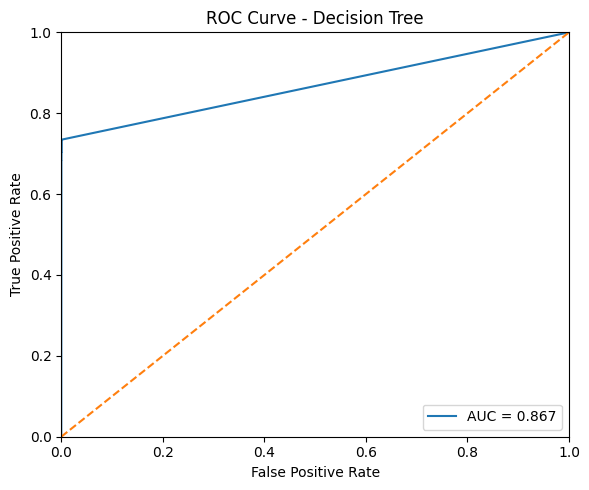

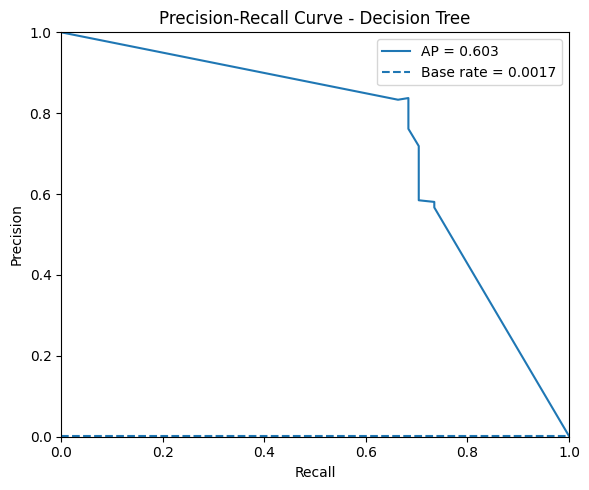

In [231]:
# --- Curvas ROC y PR ---
# ROC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
roc_auc_tree = roc_auc_score(y_test, y_proba_tree)

plt.figure(figsize=(6,5))
plt.plot(fpr_tree, tpr_tree, label=f"AUC = {roc_auc_tree:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR - Precision-Recall Curve
prec_tree, rec_tree, _ = precision_recall_curve(y_test, y_proba_tree)
ap_tree = average_precision_score(y_test, y_proba_tree)
baseline_tree = (y_test.sum() / len(y_test))  # línea base PR = prevalencia de la clase positiva

plt.figure(figsize=(6,5))
plt.plot(rec_tree, prec_tree, label=f"AP = {ap_tree:.3f}")
plt.hlines(baseline_tree, 0, 1, linestyles="--", label=f"Base rate = {baseline_tree:.4f}")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Decision Tree")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

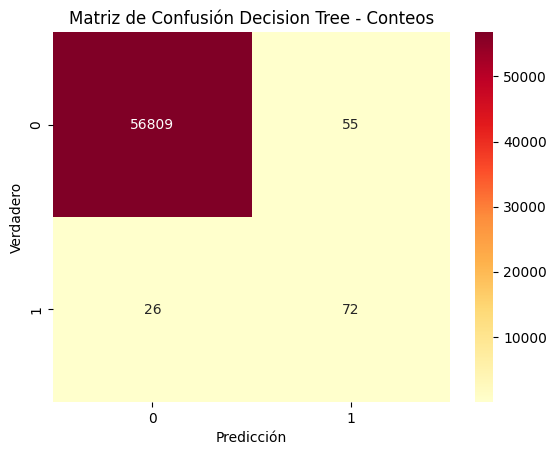

In [232]:
# --- Matriz de confusión ---
cm_tree = confusion_matrix(y_test, y_pred_tree)  # [[TN, FP],[FN, TP]]

# Conteos absolutos
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Matriz de Confusión Decision Tree - Conteos")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [234]:
param_rf = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [5, 10, None]
}

rf = Pipeline([
    ("pre", pre),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced_subsample"))
])

grid_rf = GridSearchCV(
    rf,
    param_grid=param_rf,
    scoring="average_precision",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
print("Mejores hiperparámetros RF:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

metrics_rf = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC-AUC": roc_auc_score(y_test, y_proba_rf),
    "PR-AUC": average_precision_score(y_test, y_proba_rf)
}

# --- Mostrar como tabla ordenada ---
results_rf = pd.DataFrame(metrics_rf, index=["Random Forest"]).T
display(results_rf.style.format("{:.4f}"))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros RF: {'model__max_depth': None, 'model__n_estimators': 200}


,Random Forest
Accuracy,0.9995
Balanced Accuracy,0.8826
Precision,0.9615
Recall,0.7653
F1,0.8523
ROC-AUC,0.9676
PR-AUC,0.8622


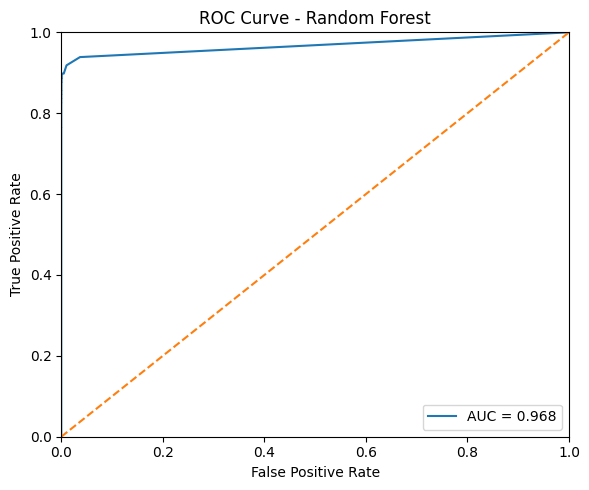

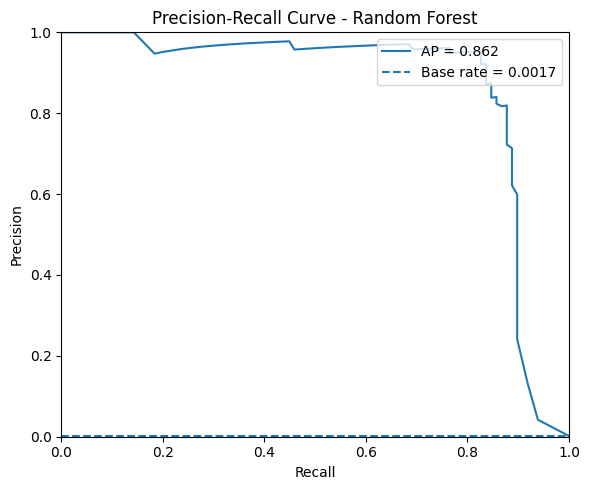

In [236]:
# --- Curvas ROC y PR ---
# ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR - Precision-Recall Curve
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
ap_rf = average_precision_score(y_test, y_proba_rf)
baseline_rf = (y_test.sum() / len(y_test))  # línea base PR = prevalencia de la clase positiva

plt.figure(figsize=(6,5))
plt.plot(rec_rf, prec_rf, label=f"AP = {ap_rf:.3f}")
plt.hlines(baseline_rf, 0, 1, linestyles="--", label=f"Base rate = {baseline_rf:.4f}")
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

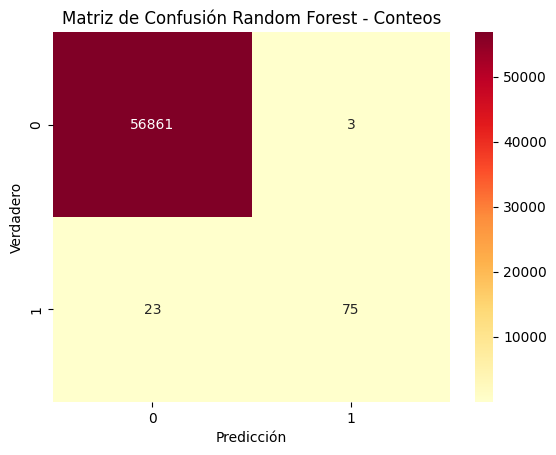

In [237]:
# --- Matriz de confusión ---
cm_rf = confusion_matrix(y_test, y_pred_rf)  # [[TN, FP],[FN, TP]]

# Conteos absolutos
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Matriz de Confusión Random Forest - Conteos")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [238]:
df_compare = pd.concat({
    "Decision Tree": results_tree,
    "Random Forest": results_rf
}, axis=1)

display(df_compare)

,Decision Tree,Random Forest
,Decision Tree,Random Forest
Accuracy,0.998578,0.999544
Balanced Accuracy,0.866863,0.882627
Precision,0.566929,0.961538
Recall,0.734694,0.765306
F1,0.640000,0.852273
ROC-AUC,0.867102,0.967572
PR-AUC,0.602740,0.862180


* **Accuracy (≈0.999 en ambos):**
  Muy alta, pero **poco informativa** en este problema, porque casi todas las transacciones son “no fraude”.

* **Balanced Accuracy:**

  * Árbol: 0.867
  * Random Forest: 0.883
  
    Ambos bastante buenos, pero el RF gana.

* **Precision (proporción de fraudes detectados que realmente lo eran):**

  * Árbol: 0.567
  * RF: 0.962 
    El Random Forest casi no da falsos positivos.

* **Recall (tasa de fraudes detectados):**

  * Árbol: 0.735
  * RF: 0.765
    Bastante parecidos, aunque RF ligeramente mejor.

* **F1 (equilibrio precision-recall):**

  * Árbol: 0.64
  * RF: 0.85
    RF mejora muchísimo, porque logra alto recall sin perder precisión.

* **ROC-AUC:**

  * Árbol: 0.867
  * RF: 0.968
    Ambos buenos, pero de nuevo RF domina.

* **PR-AUC (Average Precision, la métrica más relevante aquí):**

  * Árbol: 0.603
  * RF: 0.862 
    El Random Forest concentra mucho mejor los fraudes en las predicciones con mayor probabilidad, lo que lo hace **más útil en un escenario real** donde se prioriza revisar las transacciones más sospechosas.

* **Random Forest > Decision Tree** en prácticamente todas las métricas, sobre todo en las más críticas (Precision, F1 y PR-AUC).
* El árbol simple es fácil de interpretar, pero no logra separar bien fraudes de no fraudes.
* El Random Forest, al promediar muchos árboles, reduce el sobreajuste y captura mejor los patrones, siendo claramente el mejor modelo de los dos.


In [241]:
!jupyter nbconvert --to markdown code.ipynb

[NbConvertApp] Converting notebook code.ipynb to markdown
[NbConvertApp] Support files will be in code_files\
[NbConvertApp] Making directory code_files
[NbConvertApp] Writing 44830 bytes to code.md
